In [4]:
import sys
sys.path.append("../")

from config import Config
conf = Config()

from typing import TypedDict, List, Dict, Optional, Literal
from datetime import datetime
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
import re
from dateutil.relativedelta import relativedelta
import pytz


In [5]:
class AgentState(TypedDict):
    messages: List[BaseMessage]            # Conversation history
    memories: Dict[str, str]               # Permanent memories (name, occupation)
    reminders: List[Dict]                  # Active reminders
    pending_reminder: Optional[Dict]       # Reminder being set
    waiting_for: Optional[Literal["frequency", "confirmation"]]  # Expected input type

In [6]:
def parse_time_expression(expression: str) -> datetime:
    """Convert time expressions to datetime objects"""
    now = datetime.now(pytz.utc)
    expression = expression.lower()
    
    if expression in ["today", "now"]:
        return now.replace(hour=12, minute=0, second=0)
    elif expression == "tomorrow":
        return (now + relativedelta(days=1)).replace(hour=9, minute=0)
    elif "next week" in expression:
        return now + relativedelta(weeks=1)
    elif "next month" in expression:
        return now + relativedelta(months=1)
    elif "next year" in expression:
        return now + relativedelta(years=1)
    # Add more cases as needed
    return now + relativedelta(hours=1)  # Default: 1 hour from now


In [7]:
def parse_frequency(text: str) -> str:
    """Extract frequency from user input (smart default: hourly)"""
    text = text.lower()
    if "daily" in text or "day" in text:
        return "daily"
    elif "weekly" in text or "week" in text:
        return "weekly"
    elif "monthly" in text or "month" in text:
        return "monthly"
    elif "yearly" in text or "year" in text:
        return "yearly"
    return "hourly"  # Default snooze frequency

In [9]:
def process_input(state: AgentState) -> AgentState:
    last_message = state["messages"][-1].content
    state["user_input"] = last_message  # Store for reference
    return state

In [11]:
def create_reminder(state: AgentState) -> AgentState:
    user_input = state["user_input"]
    
    # Extract reminder details using regex
    match = re.search(r"remind me to (.+?) (every|on|at|tomorrow|next)", user_input, re.IGNORECASE)
    if not match:
        return {
            **state,
            "messages": state["messages"] + [AIMessage(content="What should I remind you about?")],
            "waiting_for": "confirmation"
        }
    
    task = match.group(1).strip()
    time_expr = user_input.split(task)[-1].strip()
    
    state["pending_reminder"] = {
        "task": task,
        "time": parse_time_expression(time_expr),
        "frequency": parse_frequency(time_expr)
    }
    
    response = f"⏰ I'll remind you to '{task}' at {state['pending_reminder']['time']:%Y-%m-%d %H:%M}."
    response += "\nHow often should I repeat? (hourly/daily/weekly/monthly)"
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response)],
        "waiting_for": "frequency"
    }

In [12]:
def finalize_reminder(state: AgentState) -> AgentState:
    if not state.get("pending_reminder"):
        return state
    
    # Apply user-specified frequency
    frequency = parse_frequency(state["user_input"])
    state["pending_reminder"]["frequency"] = frequency
    
    # Save to active reminders
    state["reminders"].append(state["pending_reminder"])
    
    # Generate confirmation message
    reminder = state["pending_reminder"]
    response = (
        f"✅ Reminder set!\n"
        f"Task: {reminder['task']}\n"
        f"Time: {reminder['time']:%Y-%m-%d %H:%M}\n"
        f"Repeats: {reminder['frequency']}"
    )
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response)],
        "pending_reminder": None,
        "waiting_for": None
    }

In [13]:
def store_memory(state: AgentState) -> AgentState:
    user_input = state["user_input"].lower()
    
    if "my name is" in user_input:
        name = user_input.split("my name is")[-1].strip()
        state["memories"]["name"] = name
        response = f"I'll remember your name is {name}!"
    elif "i am a" in user_input or "i'm a" in user_input:
        occupation = re.split(r"i am a |i'm a ", user_input)[-1].split(".")[0].strip()
        state["memories"]["occupation"] = occupation
        response = f"Got it! You're a {occupation}."
    else:
        response = "I didn't catch what to remember. Try 'My name is...' or 'I am a...'"
    
    return {
        **state,
        "messages": state["messages"] + [AIMessage(content=response)]
    }

In [17]:
from langchain_community.chat_models import ChatOpenAI

def general_response(state: AgentState) -> AgentState:
    chat = ChatOpenAI(model="gpt-3.5-turbo")
    response = chat.invoke(state["messages"])
    return {
        **state,
        "messages": state["messages"] + [response]
    }


# Conditional routing
def route_decision(state: AgentState) -> str:
    if state.get("waiting_for") == "frequency":
        return "finalize_reminder"
    
    if "remind" in state["user_input"].lower():
        return "create_reminder"
    
    if any(k in state["user_input"].lower() for k in ["name is", "i am a", "i'm a"]):
        return "store_memory"
    
    return "general_response"

In [21]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("process_input", process_input)
workflow.add_node("create_reminder", create_reminder)
workflow.add_node("finalize_reminder", finalize_reminder)
workflow.add_node("store_memory", store_memory)
workflow.add_node("general_response", general_response)

# Set entry point
workflow.set_entry_point("process_input")

# Conditional routing - DIRECTLY from process_input
def route_decision(state: AgentState) -> str:
    if state.get("waiting_for") == "frequency":
        return "finalize_reminder"
    
    user_input = state["user_input"].lower()
    
    if "remind" in user_input:
        return "create_reminder"
    
    if any(k in user_input for k in ["name is", "i am a", "i'm a"]):
        return "store_memory"
    
    return "general_response"

# Add conditional edges DIRECTLY from process_input
workflow.add_conditional_edges(
    "process_input",  # Source node
    route_decision,   # Router function
    {
        "create_reminder": "create_reminder",
        "finalize_reminder": "finalize_reminder",
        "store_memory": "store_memory",
        "general_response": "general_response"
    }
)

# Connect action nodes to END
workflow.add_edge("create_reminder", END)
workflow.add_edge("finalize_reminder", END)
workflow.add_edge("store_memory", END)
workflow.add_edge("general_response", END)

agent = workflow.compile()

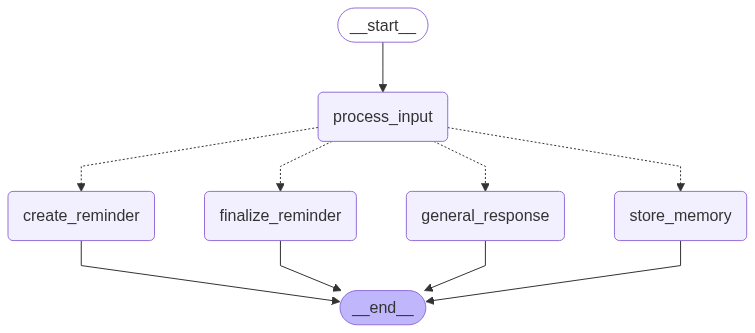

In [22]:
agent

In [ ]:
# Initialize agent
state = {
    "messages": [AIMessage(content="Hello! How can I help you?")],
    "memories": {},
    "reminders": [],
    "pending_reminder": None,
    "waiting_for": None
}

# User interaction loop
while True:
    user_input = input("You: ")
    state["messages"].append(HumanMessage(content=user_input))
    
    # Execute agent
    state = agent.invoke(state)
    
    # Print last AI response
    print(f"Agent: {state['messages'][-1].content}")
    
    # Check reminders (simulated)
    for reminder in state["reminders"]:
        if datetime.now(pytz.utc) >= reminder["time"]:
            print(f"\n🔔 REMINDER: {reminder['task']}")
            # Update next reminder time based on frequency
            if reminder["frequency"] == "daily":
                reminder["time"] += relativedelta(days=1)
            # Add other frequency updates...